In [2]:
import numpy as np
import pandas as pd

data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

In [3]:
train.shape, test.shape

((10886, 12), (6493, 9))

In [4]:
train.head()
# datetime부터 registered까지는 예측에 사용할 수 있는 피처이고, count는 예측해야할 타깃값이다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [5]:
test.head()
# 테스트 데이터는 피처 수가 훈련 데이터보다 적다.
# 훈련 데이터의 피처에서 casual과 registered가 빠졌다.(등록되지 않은 사용자수, 등록된 사용자수)
# 훈련데이터를 호라용해 모델을 훈련한 뒤, 테스트 뎅티ㅓ를 활용해 대여 수량을 예측해야하는데, 예측할때 사용하는 데이터가 테스트 데이터이다.
# 그런데 테스트 데이터에 casual과 registered 피처가 없으므로 훈련할때도 훈련 데이터의 casual과 registered피처를 빼야한다.

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
submission.head()
# 샘플 파일이 어떻게 생겼는가?
# 제출 파일은 보통 이런 형태이다. 데이터를 구분하는 ID 값과 타깃값으로 구성되어 있다.
# 현재 타깃값인 count가 모두 0이다. 시간대별 대여 수량을 예측해 이 값을 바꾼 뒤 제출하면 된다.
# 여기에서 ID값인 datetime은 데이터를 구분하는 역할만하므로 타깃값을 예측하는 데에는 아무런 도움을 주지 않는다.
# 따라서 추후 모델 훈련 시 훈련 데이터에 있는 datetime 피처는 제거할 계획이다.

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


- train, test모두 결측값이 없고, 데이터 타입도 훈련 데이터와 동일하다

## 피처 엔지니어링
- 기본적인 분석을 마쳤다면 다음은 데이터 시각화 차례이다.
- 데이터를 다양한 관점에서 시각화해보면 날 데이터 상태에서는 찾기 어려운 경향, 공통점, 차이 등이 드러날 수 있기 때문이다.
- 그런데 일부 데이터는 시각화하기에 적합하지 않은 형태일 수 있다.
- 본 경진대회에서는 datetime 피처가 그렇다. 시각화하기 전에, 이 피철르 분석하기에 적합한 변환을 해볼 것이다.


- datetime 피처의 데이터 타입은 object이다. 판다스에서 object 타입은 문자열 타입이라고 보면된다.
- datetime은 연도, 일, 시간, 분, 초로 구성되어 있다. 따라서 세부적으로 분석해보기 위해 구성요소별로 나누어  보겠다.

In [9]:
print(train['datetime'][50])
print(train['datetime'][50].split())
print(train['datetime'][50].split()[0])
print(train['datetime'][50].split()[1])

2011-01-03 05:00:00
['2011-01-03', '05:00:00']
2011-01-03
05:00:00


- datetime 피처는 object 타입이기 때문에 문자열처럼 다룰 수 있다.
- 앞의 예에서는 split() 함수를 사용해 공백 기준으로 앞 뒤 문자를 나누었다. 
- 날짜문자열을 다시 연도, 월, 일로 나눠보겠다.

In [10]:
print(train['datetime'][50].split()[0])
print(train['datetime'][50].split()[0].split('-'))
print(train['datetime'][50].split()[0].split('-')[0])
print(train['datetime'][50].split()[0].split('-')[1])
print(train['datetime'][50].split()[0].split('-')[2])


2011-01-03
['2011', '01', '03']
2011
01
03


- 이어서 시간 문자열을 시, 분, 초로 나눠보겠다.

In [11]:
print(train['datetime'][50].split()[1])
print(train['datetime'][50].split()[1].split(':'))
print(train['datetime'][50].split()[1].split(':')[0])
print(train['datetime'][50].split()[1].split(':')[1])
print(train['datetime'][50].split()[1].split(':')[2])

05:00:00
['05', '00', '00']
05
00
00


- 다음으로 판다스 apply() 함수로 앞의 로직을 datetime에 적용해 date, year, month, day, hour, minute, second 피처를 생성해보겠다.

In [12]:
train['date'] = train['datetime'].apply(lambda x : x.split()[0])

# 연도, 월, 일, 시, 분, 초 피처를 차례로 생성
train['year'] = train['datetime'].apply(lambda x:x.split()[0].split('-')[0])
train['month'] = train['datetime'].apply(lambda x:x.split()[0].split('-')[1])
train['day'] = train['datetime'].apply(lambda x:x.split()[0].split('-')[2])
train['hour'] = train['datetime'].apply(lambda x:x.split()[1].split(':')[0])
train['minute'] = train['datetime'].apply(lambda x:x.split()[1].split(':')[1])
train['second'] = train['datetime'].apply(lambda x:x.split()[1].split(':')[2])

- apply() 함수는 DataFrame의 데이터를 일괄 가공해준다.
- 보다시피 종종 람다(lambda)함수와 함께 사용된다.
- 람다 함수를 DataFrame 축(기본값은 DataFrame의 각 열(column)에 대해 수행)을 따라 적용하는 기능을 한다.
- 연도 피처를 추가하는 코드를 예로 동작 방식을 자세히 살펴보겠다.



> train['year'] = train['datetime'].apply(lambda x:x.split()[0].split('-')[0])


- train['datetime'] -> train의 'datetime' 피처의 원소 각각에
- .apply -> 람다 함수를 적용하여
- train['year'] -> year 피처로 추가한다.
- x.split()[0] -> 공백으로 나눈 후 0번째 요소를
- .split('-')[0] -> 다시 '-'로 나눈 후 0번째 요소를 취한다.

- 이제 요일 피처도 생성해보겠다.
- 요일 피처응 calendar와 datetime '라이브러리'를 활용해 만들 수 있다.
- 여기서 datetime은 날짜와 시간을 조작하는 라이브러리로 datetime 피처와는 다른 것이다.
- 날짜 문자열에서 요일을 추출하는 방법을 한 단계씩 알아보겠다. 

In [13]:
from datetime import datetime
import calendar

print(train['date'][100]) # 날짜 
print(datetime.strptime(train['date'][100], '%Y-%m-%d')) # datetime 타입으로 변경

# 정수로 요일 반환
print(datetime.strptime(train['date'][100], '%Y-%m-%d').weekday())


# 문자열로 요일 반환
print(calendar.day_name[datetime.strptime(train['date'][100], '%Y-%m-%d').weekday()])

2011-01-05
2011-01-05 00:00:00
2
Wednesday


- 다소 복잡하지만 calendar와 datetime 라이브러리를 사용하면 요일 피처를 문자로 구할 수 있다.
- 0은 월요일, 1은 화용,ㄹ 2는 수요일순으로 매핑된다.
- 단, 모델을 훈련할 때는 피처값을 문자로 바꾸면 안된다.
- 머신러닝 모델은 숫자만 인식하기 때문이다. 문자 피처도 모두 숫자로 변환해야한다.
- 여기서는 그래프로 나타냈을 때 쉽게 알아보려고 요일 피처를 문자열로 바꾼 것이다. 

- 앞의 로직을 apply() 함수로 적용해 요일(weekday)피처를 추가하겠다.

In [14]:
train['weekday'] = train['date'].apply(lambda dateString: calendar.day_name[datetime.strptime(dateString,'%Y-%m-%d').weekday()])

- 다음은 season과 weather 피처 차례이다.
- 이 두 피처는 범부형 데이터인데 현재 1,2,3,4라는 숫자로 표현되어 있어서 정확히 어떤 의미인지 파악하기 어렵다.
- 시각화 시 의미가 잘 드러나도록 map() 함수를 사용하여 문자열로 바꾸겠다.

In [15]:
train['season'] = train['season'].map({1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'})
train['weather'] = train['weather'].map({1:'Clear', 2:'Mist, Few clouds', 3:'Light Snow, Rain, Thunderstorm',
                                        4:'Heavy Rain, Thunderstorm, Snow, Fog'})

In [16]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,date,year,month,day,hour,minute,second,weekday
0,2011-01-01 00:00:00,Spring,0,0,Clear,9.84,14.395,81,0.0,3,13,16,2011-01-01,2011,01,01,00,00,00,Saturday
1,2011-01-01 01:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,8,32,40,2011-01-01,2011,01,01,01,00,00,Saturday
2,2011-01-01 02:00:00,Spring,0,0,Clear,9.02,13.635,80,0.0,5,27,32,2011-01-01,2011,01,01,02,00,00,Saturday
3,2011-01-01 03:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,3,10,13,2011-01-01,2011,01,01,03,00,00,Saturday
4,2011-01-01 04:00:00,Spring,0,0,Clear,9.84,14.395,75,0.0,0,1,1,2011-01-01,2011,01,01,04,00,00,Saturday


- date, year, month, day, hour, minute, second, weekday 피처가 추가되었고, season과 weather 피처는 숫자에서 문자로 바뀌었다.
- 참고로 date 피처가 제공하는 정보는 모두 year, month, day 피처에도 있어서 추후 date 피처는 제거하겠다.
- 또한 세달 씩 월을 묶으면 게절이 된다. 즉, 세분화도니 month 피처를 세달씩 묶으면 season 피처와 의미가 같아진다. 지나치게 세분화된 피처를 더 큰 분류로 묶으면 성능이 좋아지는 경우가 있어 여기에서는 season피처만 남기고 month 피처는 제거하겠다.

## 데이터 시각화

- 피처를 추가한 훈련 데이터를 그래프로 시각화해보겠다.
- 시각화는 탬색적 데이터 분석에서 가장 중요한 부분이다.
- 데이터 분포나 데이터 간 관계를 한눈에 파악할 수 있기 때문이다.
- 모델링에 도움될만한 정보를 얻을 수도 있다.


- 시각화를 위해 matplotlib과 seaborn 라이브러리를 활용하겠다. matplotlib은 파이써능로 데이터를 시각화할때 표준처럼 사용되는 라이브러리이며,
- seaborn은 matplotlib에 고수준 인터페이스를 덧씌운 라이브러리이다.

In [17]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


- 참고로 코드 %matplotlib inline을 추가하면 matplotlib이 그린 그래프를 주피터 노트북에서 바로 출력해준다.
- 사실 캐글 환경에서는 %matplotlib inline이 없어도 그래프를 보여주지만, matplotlb를 사용하는 경우 관습적으로 쓰는 경향이 있다.

### 분포도
- 분포도(distribution plot)는 수치형 데이터의 집계를 나타내는 그래프이다. 
- 집계 값은 총 개수난 비율 등을 의미한다.
- 타깃값인 count의 분포도를 그려보겠다.
- 이번장에서는 타깃값의 분포를 알면 훈련 시 타깃값을 그대로 사용할지 변환해 사용할지 파악할 수 있기 때문이다.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


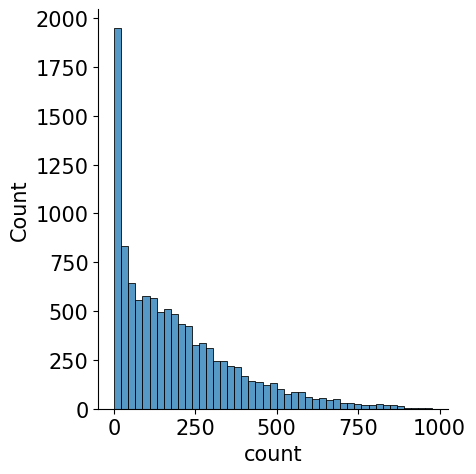

In [18]:
mpl.rc('font', size=15)
sns.displot(train['count']);

- x축은 타깃값인 count를 나타내고, y축은 총 개수를 나타낸다.
- 분포도를 보면 타깃값인 count가 0근처에 몰려있다.
- 즉, 분포가 왼쪽으로 많이 편향되어 있다.
- 회귀모델이 좋은 성능을 내려면 데이터가 정규분포를 따라야 하는데, 현재 타깃값 count는 정규분포를 따르지 않는다.
- 따라서 현재 타깃값을 그대로 사용해 모델링한다면 좋은 성능을 기대하기가 어렵다.


- 데이터 분포를 정규분포에 가깝게 만들기 위해 가장 많이 사용하는 방법은 로그변환이다.
- 로그변환은 count 분포와 같이 데이터가 왼쪽으로 편향되어 있을 때 사용한다.
- 로그변환하는 방법은 간단하다.
- 원하는 값에 로그를 취해주면 된다. count를 로그변환한 값의 분포를 살펴보겠다.

/opt/conda/lib/python3.10/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


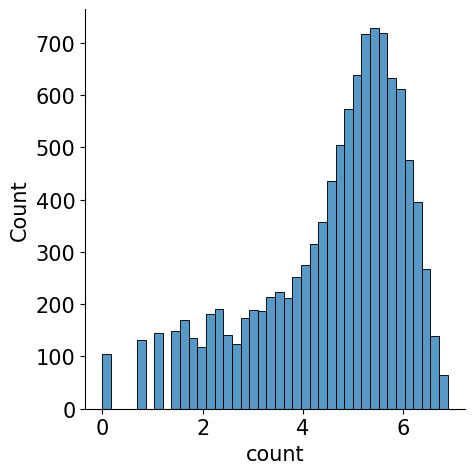

In [19]:
sns.displot(np.log(train['count']));

- 변환전보다 정규분포에 가까워졌다.
- 타깃값 분포가 정규분포에 가까울수록 회귀 모델 성능이 좋다고 했다.
- 다시말해, 피처를 바로 활용해 count를 예측하는것보다 log(count)를 예측하는 편이 더 정확하다.
- 따라서 우리도 타깃값을 log(count)로 변환해 사용하겠다.


- 다만 마지막에 지수변환을 하여 실제 타깃값인 count로 복원해야한다.
- log(y)를 지수변환하면 y가 된다.

### 막대 그래프
- 다음으로 연도, 월, 일, 시, 분, 초별로 총 여섯 가지의 평균 대여 수량을 막대 그래프로 그려보겠다.
- 이 피처들은 범부형 데이터이다. 각 범주형 데이터에 따라 평균 대여 수량이 어떻게 다른지 파악하려고 한다. 그래야 어떤 피처가 중요한지 알 수 있다.
- 이럴 때 막대 그래프를 이용한다. 막대그래프는 seaborn의 barplot()함수로 그릴 수 있다. 




- 연도별 평군 대어 수량 그래프를 보면 2011년보다 2012년에 대여가 더 많다.
- 2번 그래프로는 월별 평균 대여수량의 추세를 파악할 수 있다. 평균 대여수량은 6월에 가장 많고, 1월에 가장 적다. 날씨가 따뜻할수록 대여수량이 많다고 짐작할 수 잇따.
- 3번은 일별 평균 대여수량 그래프이다. 일별 대여수량에는 뚜렷한 차이가 없다. 소개 페이지에서 말했다시피 훈련 데이터에는 매우러 1일부터 19일까지의 데이터만 있다. 나머지 20일부터 우러말까지의 데이터는 테스트 데이터에 있다. 그래서 일자(day)는 피처로 사용하지 못한다. day를 피처로 사용하려면 훈련 데이터와 테스트 데이터에 공통된 값이 있어야 하는데, 훈련 데이터의 day와 테스트 데이터의 day는 전혀 다른 값을 갖기 때문이다.
- 4번 그래프는 시간별 평균 대여 수량이다. 그래프 모양이 쌍봉형이다. 새벽 4시에 대여수량이 가장 적다.당연하다. 새벽 4시에 자전거를 타는 사람은 거의 없을 테니까 말이다. 반면에 아침 8시와 저녁 5~6시에 대여가 가장 많다. 사람들이 등하교 혹은 출퇴근 길에 자전거를 많이 이용한다고 짐작해볼 수 있다.
- 5,6에 있는 분별, 초별 평균 대여수량 그래프는 아무 정보도 담고 있지 않다. 훈련 데이터에 분과 초는 모두 0으로 기록되어 있기 때문이다. 따라서 나중에 모델을 훈련할때 분과 초 피처는 사용하지 않겠다.

#### 스텝1 : m행 열 Figure 준비하기
- 첫번째로 총 6개의 그래프(서브플롯)를 품는 3행 2열짜리 Figure를 준비한다.

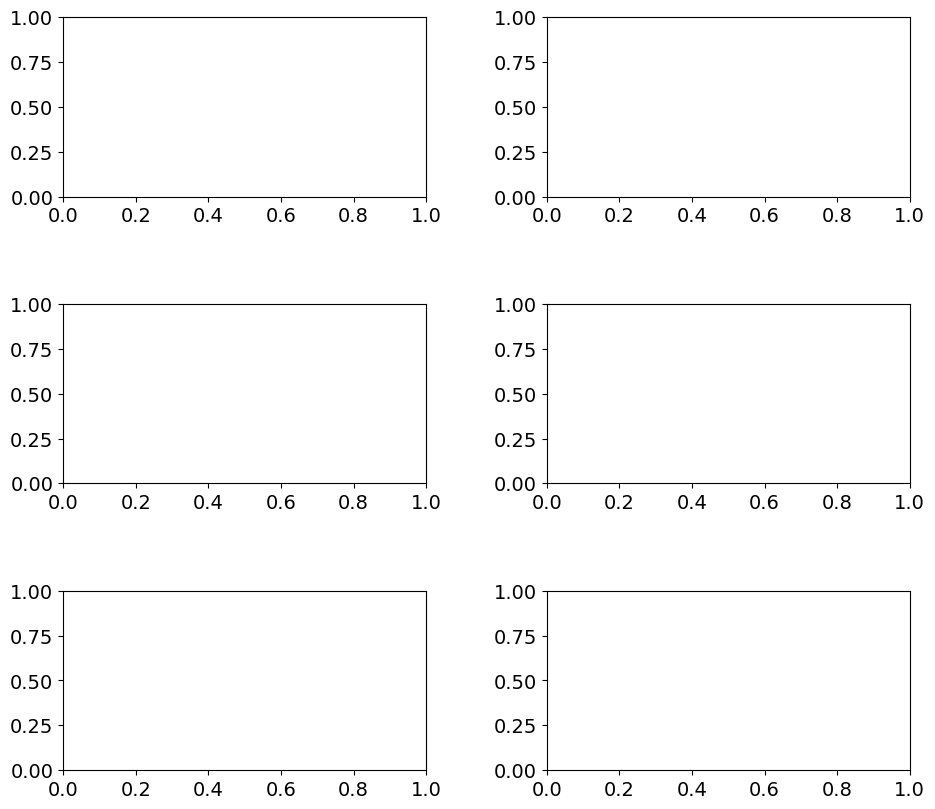

In [20]:
mpl.rc('font', size=14) # 폰트 크기 설정
mpl.rc('axes', titlesize=15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성 (1)
plt.tight_layout() # 그래프 사이에 여백 확복 (2)
figure.set_size_inches(10,9) # 전체 Figure 크기를 10X9인치로 설정 (3)


- (1)은 matplotlib 라이브러리의 subplots() 함수 사용 예시이다. 지금 예처럼 한 화면에 여러 그래프를 동시에 그릴 때 사용된다. 파라미터를 두 개 받는데 nrows는 행 갯수를, ncols는 열 개수를 뜻한다. (1)을 실행하면 3행 2열의 서브플롯 전체가 figure 변수에할당되며, 각각의 서브플롯 축 6개는 axes 변수에 할당된다. 다음 그림은 (1) 까지만 실행해 figure를 출력해본 모습이다.

In [21]:
axes

array([[<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >],
       [<Axes: >, <Axes: >]], dtype=object)

- AxesSubplot 객체가 6개가 3행 2열로 구성된 배열이 출력되었다.
- 이 배열을 입력으로 axes.shape를 실행하면 (3,2)가 출력된다. 
- 출력 결과의 각 AxesSubplot 객체는 순서대로 서브플롯의 0행, 0열, 1행 0열, 1행1열, 2행0열, 2행1열 축을 의미한다. 예를 들어, axes[0,0]은 서브플롯의 0행0열 축을 의미한다.
- (2)의 plt.tight_layout()은 서브플롯 사이에 여백을 줘 간격을 넓히는 기능을 한다. 앞의 그림에서는 서브플롯 사이의 간격이 좁아 숫자가 일부 가려져 보기 좋지 않다. 그렇다면 이 함수를 적용하면 어떻게 바뀔까?

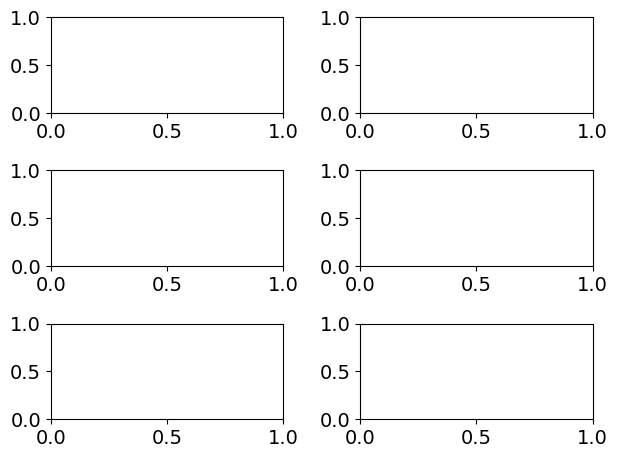

In [22]:
figure, axes = plt.subplots(nrows=3, ncols=2)
plt.tight_layout()

- (3)의 figure.set_size_inches(10,9)로는 Figure크기를 지정한다.
- 서브플롯 하나의 크기가 아니라 서브플롯 6개를 합친 전체 figure 크기이며, 단위는 함수 이름에서 알 수 있듯이 인치이다.
- 첫번째 파라미터로는 너비, 두번째 파라미터로는 높이를 조정한다.
- 여기서는 너비 10인치, 높이 9인치로 설정했다.

#### 스텝 : 각 축에 서브플롯에 할당
- 이어서 연도, 월, 일, 시간, 분, 초별 평균 대어 수량 막대 그래프를 스텝 1에서 준비한 figure의 각 축에 할당해보겠다.

In [23]:
sns.barplot(x='year', y='count', data=train, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train, ax=axes[2,1])

<Axes: xlabel='second', ylabel='count'>

- 막대 그래프 생성에는 seaborn의 barplot()함수를 이용했다.
- x파라미터에 연도, 월, 일, 시간, 분, 초를 전달하고, y 파라미터에 파라미터에 대여 수량을 전달했다.
- data 파라미터에는 훈련 데이터를 DataFrame 형식으로 전달하면 된다.
- ax 파라미터에는 AxesSubplot 객체를 전달하면된다. 0행 0열의 축부터 2행 1열의 축까지 순서대로 전달했다.
- 그럼 서브플롯들이 잘 설명되었는지, 스텝 2 코드까지 실행해보자

#### 스텝3 : (선택) 세부 설정
- 아쉬움이 남는다면 다양한 형태로 세부 속성을 설정할 수 잇다.
- 이번 예에서는 각 서브플롯에 제목을 추가하고 x축 라벨이 겹치지 않게 개선해보겠다.
- 먼저 각 축에 그려진 서브플롯에 제목을 달아준다.

In [24]:
axes[0,0].set(title='Rental amounts by year')
axes[0,1].set(title='Rental amounts by month')
axes[1,0].set(title='Rental amounts by day')
axes[1,1].set(title='Rental amounts by hour')
axes[2,0].set(title='Rental amounts by minute')
axes[2,1].set(title='Rental amounts by second')

[Text(0.5, 1.0, 'Rental amounts by second')]

- 이어서 1행의 두 서브플롯의 x축 라벨들을 90도 회전시키겠다.

In [25]:
axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)

- 보다시피 axis 파라미터에 원하는 축을 명시하고 labelrotation 파라미터에 회전 각도를 입력하면 된다.
- axis의 값으로는 'x', 'y', 'both'를 지정할 수 있으며, 기본값이 'both'이므로 생략하면 두 추을 한꺼번에 회전시킨다.

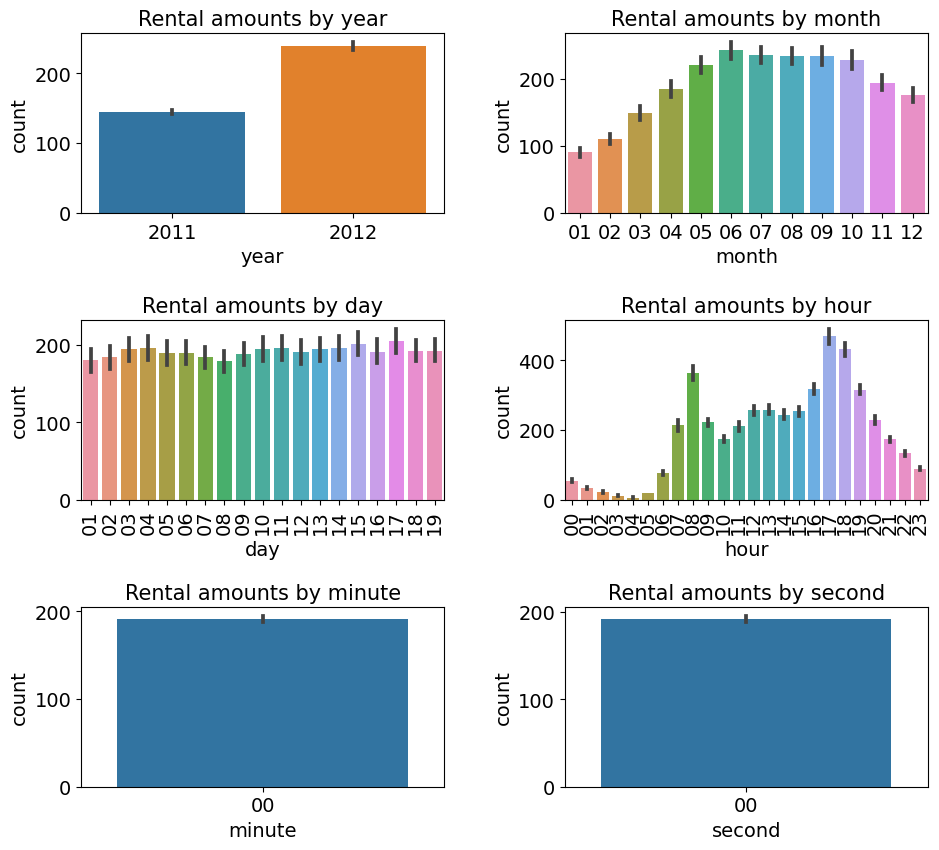

In [26]:
mpl.rc('font', size=14) # 폰트 크기 설정
mpl.rc('axes', titlesize=15) # 각 축의 제목 크기 설정
figure, axes = plt.subplots(nrows=3, ncols=2) # 3행 2열 Figure 생성 (1)
plt.tight_layout() # 그래프 사이에 여백 확복 (2)
figure.set_size_inches(10,9) # 전체 Figure 크기를 10X9인치로 설정 (3)

sns.barplot(x='year', y='count', data=train, ax=axes[0,0])
sns.barplot(x='month', y='count', data=train, ax=axes[0,1])
sns.barplot(x='day', y='count', data=train, ax=axes[1,0])
sns.barplot(x='hour', y='count', data=train, ax=axes[1,1])
sns.barplot(x='minute', y='count', data=train, ax=axes[2,0])
sns.barplot(x='second', y='count', data=train, ax=axes[2,1])

axes[0,0].set(title='Rental amounts by year')
axes[0,1].set(title='Rental amounts by month')
axes[1,0].set(title='Rental amounts by day')
axes[1,1].set(title='Rental amounts by hour')
axes[2,0].set(title='Rental amounts by minute')
axes[2,1].set(title='Rental amounts by second')

axes[1,0].tick_params(axis='x', labelrotation=90)
axes[1,1].tick_params(axis='x', labelrotation=90)

### 박스플롯
- 박스플롯은 범주형 데이터에 따른 수치형 데이터 정보를 나타내는 그래프이다. 막대 그래프보다 더 많은 정보를 제공하는 특징이 있다.
- 여기서는 계절, 날씨, 공휴일, 근무일(범주형 데이터)별 대여 수량(수치형 데이터)을 박스플롯으로 그려보겠다. 각 범주형 데이터에 따라 타깃값인 대여 수량이 어떻게 변하는지 알 수 있다.
- 이번에는 2행 2열 figure를 만들 것이며, 코드는 막대 그래프 때와 같은 figure 준비 -> 서브플롯 할당 -> 세부 설정 순서로 작성했다.

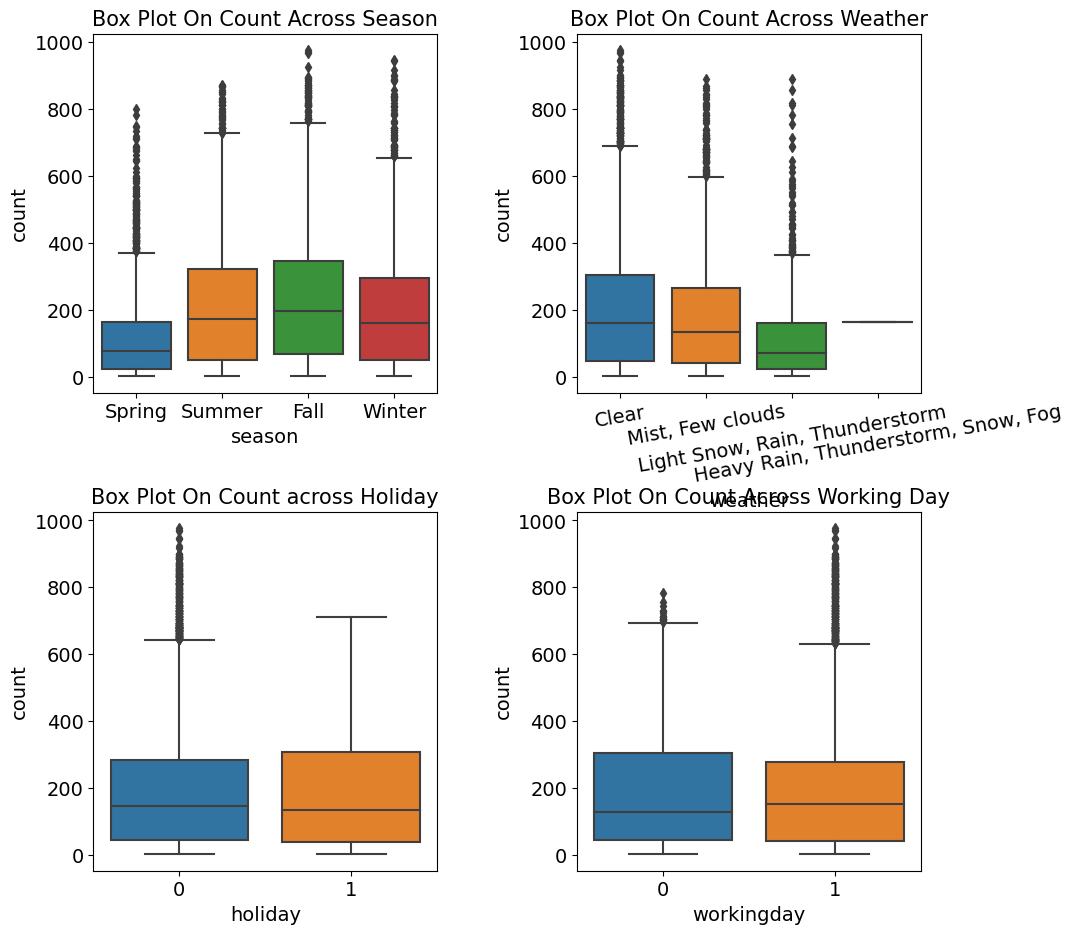

In [27]:
# 스텝1 : m행 2열 figure 준비
figure, axes= plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(10,10)

# 스텝 2 : 서브플롯 할당
# 계절, 날씨, 공휴일, 근무일별 대여 수량 박스플롯
sns.boxplot(x='season', y='count', data=train, ax=axes[0,0])
sns.boxplot(x='weather', y='count', data=train, ax=axes[0,1])
sns.boxplot(x='holiday', y='count', data=train, ax=axes[1,0])
sns.boxplot(x='workingday', y='count', data=train, ax=axes[1,1])

# 스텝3 : 세부 설정
# 3-1 : 서브플롯에 제목달기
axes[0,0].set(title='Box Plot On Count Across Season')
axes[0,1].set(title='Box Plot On Count Across Weather')
axes[1,0].set(title='Box Plot On Count across Holiday')
axes[1,1].set(title='Box Plot On Count Across Working Day')

# 3-2 : x축 라벨 겹침 해결
axes[0,1].tick_params(axis='x', labelrotation=10)

- (1)번의 계절별 대여수량 박스플롯은 자전거 대여 수량은 봄에 가장 적고 가을에 가장 많은 것을 알 수 있다.
- (2) 박스플롯이 보여주는 날씨별 대여 수량은 우리의 직관과 일치한다. 날씨가 좋을때 수량이 가장 많고, 안좋을수록 수량이 적다. 폭우, 폭설이 내리는 날씨에는 대여 수량이 거의 없다.
- (3)은 공휴일 여부에 따른 대여수량을 나타내는 박스플롯이다. x축 라벨0은 공휴일이 아니라는 듯이고, 1은 공휴일이라는 뜻이다. 공휴일일 때와 아닐때 자전거 대여 수량의 중앙ㄱ밧은 거의 비슷하다. 다만, 공휴일이 아닐때는 이상치가 많다.
- (4)의 박스플롯도 마찬가지다. 근무일 여부에 따른 대여 수량을 나타내는데, 근무일일 때 이상치가 많다. 참고로 근무일은 공휴일과 주말을 밴 나머지 날을 뜻한다.

### 포인트플롯
- 다음으로 근무일, 공휴일, 요일, 계절, 날씨에 따른 시간대별 평균 대여 수량을 포인트플롯으로 그려보겠다.
- 포인트플롯은 범주형 데이터에 따른 수치형 데이터의 평균과 신뢰구간을 점과 선으로 표시한다.
- 막대그래프와 동일한 정보를 제공하지만, 한 화면에 여러 그래프를 그려 서로 비교해보기에 더 적합하다.

<Axes: xlabel='hour', ylabel='count'>

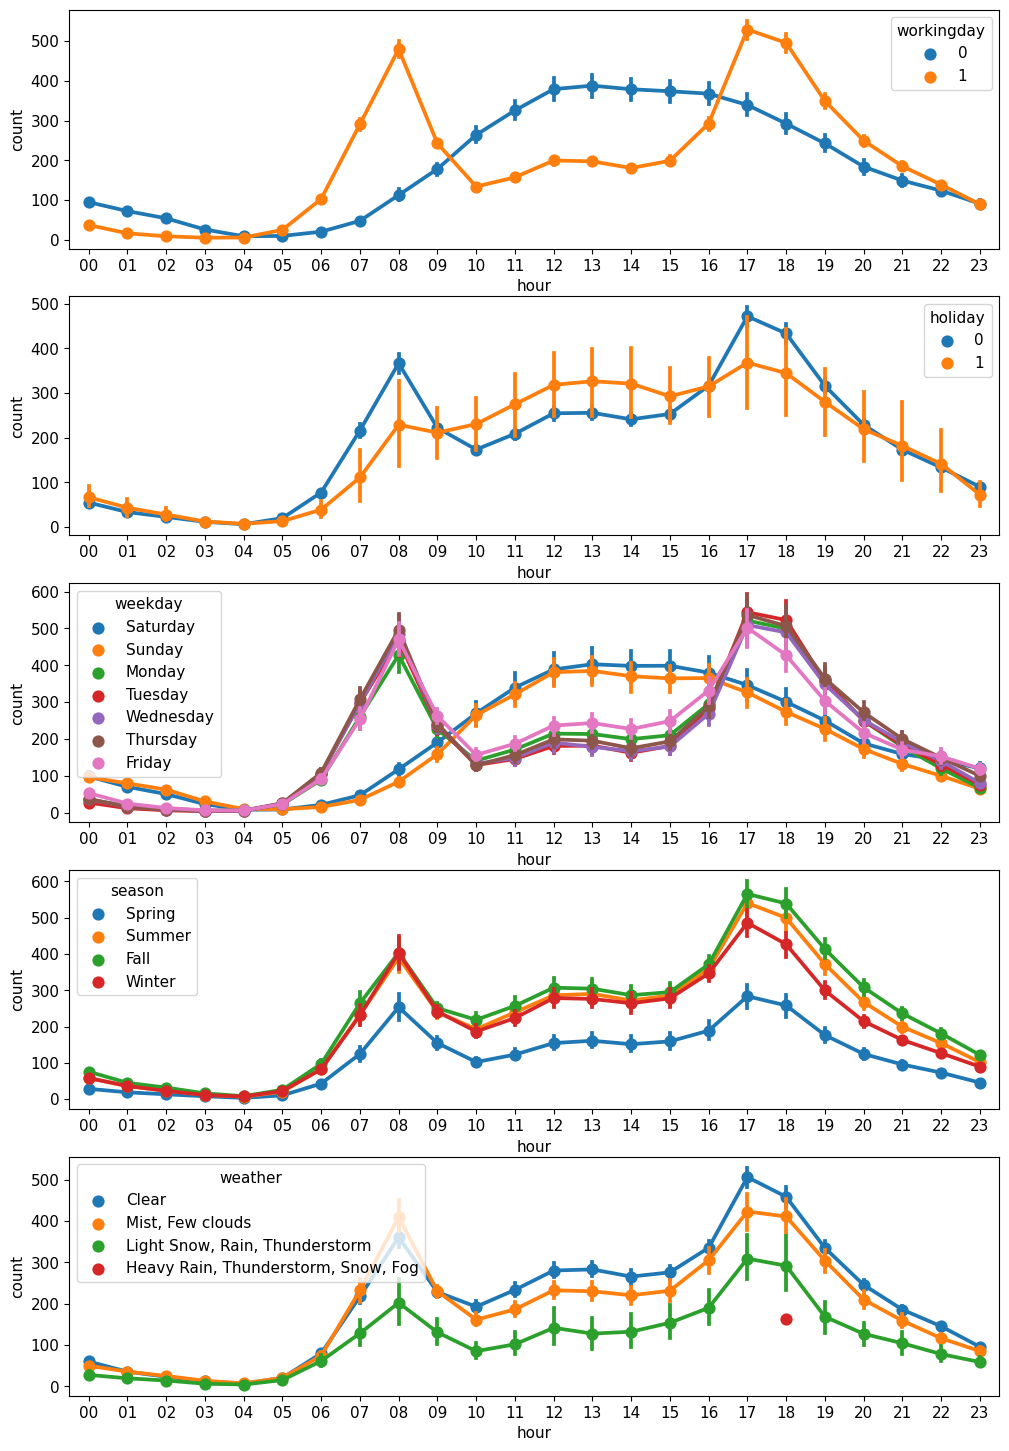

In [28]:
# 스텝1 : m행, n열 Figure 준비
mpl.rc('font', size=11)
figure, axes = plt.subplots(nrows=5) # 5행 1열
figure.set_size_inches(12,18)

# 스텝2 : 서브플롯 할당
# 근무일, 공휴일, 요일, 게절, 날씨에 따른 시간대별 평균 대여 수량 포인트 플롯
sns.pointplot(x='hour', y='count', data=train, hue='workingday', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', ax=axes[4])

- 모든 포인트플롯의 hue 파라미터에 비교하고 싶은 피처를 전달했다. hue 파라미터에 전달한 피처를 기준으로 그래프가 나뉜다.
- (1)번 그래프를 보면 근무일에는 출퇴근 시간에 대여 수ㅜ량이 많고 쉬는 날에는 오후 12~2시에 가장 많다.
- (2) 공휴일 여부, (3) 요일에 따른 포인트플롯도 근무일 여부에 따른 포인트플롯(1)과 비슷한 양상을 보인다.
- (4) 계절에 따른 시간대별 포인트플롯을 보겠다. 대여 수량은 가을에 가장 많고, 봄에 가장 적다.
- (5) 마지막 그래프는 날씨에 따른 시간대별 포인트플롯이다. 예상대로 날씨가 좋을 때 대여량이 가장 많다. 그런데 폭우, 폭설이 내릴 때 18시에 대여건수가 있다. 아마도 정말 급한 일이었지 않을까? 이런 이상치는 제거를 고혀해보는 것도 괜찮은 방법이다.

### 회귀선을 포함한 산점도 그래프
- 수치형 데이터인 온도, 체감 온도, 풍속, 습도별 대여수량을 '회귀선을 포함한 산점도 그래프'로 그래보겠다.
- 회귀선을 포함한 산점도 그래프는 수치형 데이터 간 상관관계를 파악하는데 사용한다.
- 이 그래프는 seaborh의 regplot()함수로 그릴 수 있다.

<Axes: xlabel='humidity', ylabel='count'>

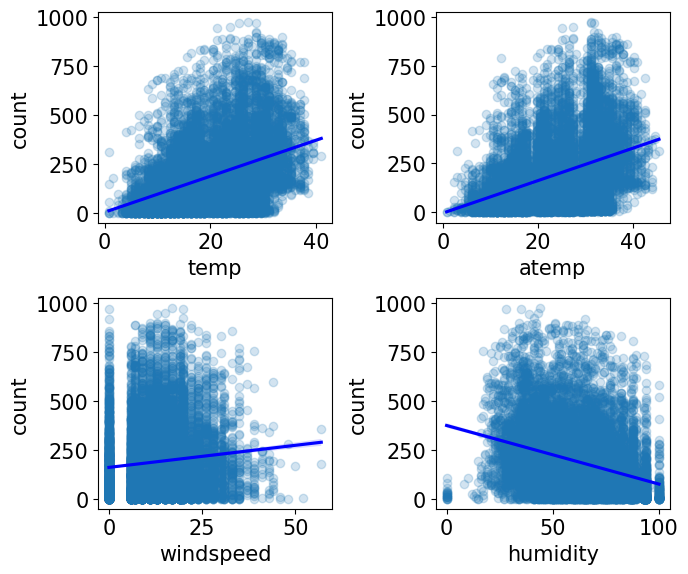

In [29]:
# 스텝1 : m행 n열 figure 준비
mpl.rc('font', size=15)
figure, axes = plt.subplots(nrows=2, ncols=2) # 2행 2열
plt.tight_layout()
figure.set_size_inches(7,6)

# 스텝 2: 서브플롯 할당
# 온도, 체감 온도, 풍속, 습도 별 대여 수량 산점도 그래프
sns.regplot(x='temp', y='count', data=train, ax=axes[0,0], scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='atemp', y='count', data=train, ax=axes[0,1], scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1,0], scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})
sns.regplot(x='humidity', y='count', data=train, ax=axes[1,1], scatter_kws={'alpha':0.2}, line_kws={'color':'blue'})

- regplot() 함수의 파라미터 중 scatter_kws={'alpha':0.2}는 산점도 그래프에 찍히는 점의 투명도를 조절한다.
- alpha를 0.2로 설정하면 평소에 비해 20% 수준으로 투명해진다. 
- alpha가 1이면 완전 불투명하고, 0이면 완전투명해서 안 보인다. 
- 이어서 line_kws={'color':'blue'}는 회귀선의 색상을 선택하는 파라미터이다. 회귀선이 잘 보이도록 그래프에 찍히는 점보다 짙은 색으로 설정했다.


- 회귀선 기울기로 대략적인 추세를 파악할수 있다. (1)과 (2) 그래프를 보면, 온도와 체감 온도가 높을수록 대여 수량이 많아진다. (4) 습도는 낮을수록 대여를 많이 한다. 다시 말해 대여 수량은 추울 때보다 따뜻할 때 많고, 습할때보다 습하지 않을 때가 많다. 여기까지는 우리의 직관과 일치한다.
- (3)번 그래프를 보겠다. 회귀선을 보면 풍속이 셀수록 대여 수량이 많다. 바람이 약할수록 많을 것 같은데 조금 이상하다. 이유는 windspeed 피처에 결측값이 많기 때문이다. 자세히 보면 풍속이 0인 데이터가 꽤 많다. 실제 풍속이 0이 아니라 관측치가 없거나 오류로 인해 0으로 기록됏을 가능성이 높다. 결측값이 많아서 그래프만으로 풍속과 대여 수량의 상관관계를 파악하기는 힘들다. 결측값이 많은 데이터는 적절히 처리해야 한다. 결측값을 다른 값으로 대체하거나 windspeed 피처를 자체를 삭제하면된다. 우리는 피처 자체를 삭제할 것이다. 

### 히트맵
- temp, atemp, humidity, windspped, count는 수치형 데이터이다. 수치형 데이터끼리 어떤 상관관계가 있는지 알아보겠다.
- corr() 함수는 DataFrame 내의 피처 간 상관계수를 계산해 반환한다.

In [30]:
train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()

,temp,atemp,humidity,windspeed,count
temp,1.000000,0.984948,-0.064949,-0.017852,0.394454
atemp,0.984948,1.000000,-0.043536,-0.057473,0.389784
humidity,-0.064949,-0.043536,1.000000,-0.318607,-0.317371
windspeed,-0.017852,-0.057473,-0.318607,1.000000,0.101369
count,0.394454,0.389784,-0.317371,0.101369,1.000000


- 하지만 조합이 많아 어느 피처들의 관계가 깊은지 한눈에 들어오지 않는다. 히트맵이 필요한 순간이다.
- 히트맵은 데이터 간 관계를 색상으로 표현하여, 여러 데이터를 한눈에 비교하기에 좋다.
- 히트맵은 seaborn의 heatmap()함수로 그릴 수 있다.

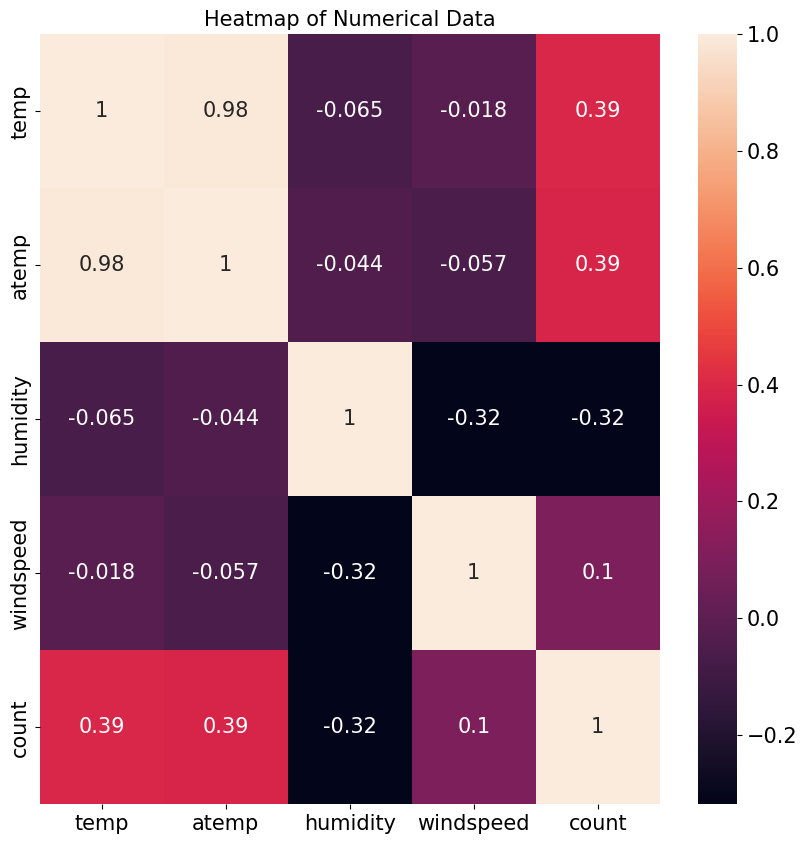

In [31]:
# 피처간 상관관계 매트릭스
corrMat = train[['temp', 'atemp', 'humidity', 'windspeed', 'count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(10,10)
sns.heatmap(corrMat, annot=True) # 상관관계 히트맵 그리기
ax.set(title='Heatmap of Numerical Data');

- (1) corr() 함수로 구한 상관관계 매트릭스 corrMat를 (2) heatmap() 함수에 인수로 넣어주면 된다. 이때 annot 파라미터를 True로 설정함녀 상관게수가 숫자로 표시된다.
- 온도와 대여 수량간 상관계수는 0.39이다. 양의 상관계수를 보인다. 온도가 높을수록 대여 수량이 많다는 뜻이다.
- 반면, 습도와 대여수량은 음수이니 습도가 낮을수록 대여수량이 많다는 뜻이다.
- 앞서 산점도 그래프에서 분석한 내용과 동일하다.
- 풍속과 대여수량의 상관계수는 0.1이다. 상관과녜가 매우 약하다. windspeed 피처는 대여 수량 예측에 별 도움을 주지 못할 것 같다.
- 성능을 높이기 위해 모델링 시 windspeed 피처는 제거하겠다. (참고로 바로 앞의 회귀선을 포함한 산점도 그래프 절에서는 결측값이 많다는 이유로 같은 결론에 도달했다.

## 분석 정리 및 모델링 전략
### 분석 정리
지금까지 다양한 측면에서 데이터를 살펴보았다. 분석과정에서 파악한 주요 내용을 정리해보겠다.
- 타깃값 변환 : 분포도 확인 결과 타깃값인 count가 0근처로 치우쳐 있으므로 로그변환하여 정규분포에 가깝게 만들어야 한다. 타깃값을 count가 아닌 log(count)로 변환해 사용할 것이므로 마지막에 다시 지수변환해 count로 복원해야한다.
- 파생 피처 추가 : datetime 피처는 여러 가지 정보의 혼합체이므로 각각을 분리해 year, month, day, hour, minute, second 피처를 생성할 수 있다.
- 파생 피처 추가 : datetime에 숨어 있는  또 다른 정보인 요일 피처를 추가하겠다.
- 피처 제거 : 테스트 데이터에 없는 피처는 훈련에 사용해도 큰 의미가 없다. 따라서 훈련 데이터에만 있는 casual과 registered 피처는 제거하겠다.
- 피처 제거 : datetime 피처는 인덱스 역할만 하므로 타깃값 예측에 아무런 도움이 되지 않는다.
- 피처 제거 : date 피처가 제공하는 정보는 year, month, day 피처에 담겨있다.
- 피처 제거 : month는 season 피처의 세부 분류로 볼 수 있다. 데이터가 지나치게 세분화되어 있으면 분류별 데이터 수가 적어서 오히려 학습에 방해가 되기도 한다.
- 피처 제거 : 막대 그래프 확인 결과 파생 피처인 day는 분별력이 없다.
- 피처 제거 : 막대 그래프 확인 결과 파생 피처인 minute와 second에는 아무런 정보가 담겨 있지 않다.
- 이상치 제거 : 포인트 플롯 확인 결과 weather가 4인 데이터는 이상치이다.
- 피처 제거 : 산점도 그래프와 히트맵 확인 결과 windspped 피처에는 결측값이 많고 대여수량과 상관관계가 매우 약하다.

### 모델링 전략
- 베이스라인 모델 : 가장 기본적인 회귀 모델인 LinearRegression 채택
- 성능 개선 : 릿지, 라쏘, 랜덤 포레스트 회귀 모델
    - 피처 엔지니어링 : 앞의 분석 수준에서 모든 모델에서 동일하게 수행
    - 하이퍼파라미터 최적화 : 그리드 서치
- 기타 : 타깃값이 count가 아닌 log(count)임

## 베이스라인 모델

- 베이스라인 모델이란 뼈대가 되는 가장 기본적인 모델을 의미한다.
- 우리는 베이스랑니 모델에서 출발해 성능을 점차 향상시키는 방향으로 모델링할 것이다. 
- 경진대회에 참가하다 보면 다른 참가다즐이 베이스라인 모델을 공유할 것이다.  공유된 모델을 사용해도 되고, 직접 자신만의 모델을 만들어도 된다.

In [32]:
import numpy as np
import pandas as pd

data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

### 피처 엔지니어링
- 피처 엔지니어링은 데이터를 변환하는 작업이다. 보통 이 변환을 훈련 데이터와 테스트 데이터에 공통으로 반영해야 하기 때문에, 피처 엔지니어링은 두 데이터를 합쳤다가 다 끝나면 다시 나눈다.
- 데이터를 합치기 전에 훈련 데이터에서 이상치 하나만 제거하고 가겠다.

#### 이상치 제거
- 앞서 포인트 플롯에서 확인한 결과 훈련 데이터에서 weather가 4인 데이터(폭우, 폭설이 내리는 날 저녁 6시에 대여)는 이상치였다.

In [33]:
# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather']!=4]

#### 데이터 합치기
- 훈련 데이터와 테스트 데이터에 같은 피처 엔지니어링을 적용하기 위해 두 데이터를 하나로 합치겠다.
- 파단스의 concat()함수를 사용하면 축을 따라 DataFrame을 이어붙일 수 잇다.
- 훈련 데이터는 10,886행 테스트 데이터는 6,493행으로 구성되어 있다.
- 합치면 17,379행이다.
- 앞서 weather가 4인 데이터를 제거했으니 최종적으로 17,378행이 된다.


In [34]:
all_data = pd.concat([train, test], ignore_index=True)
all_data

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,3.0,13.0,16.0
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,8.0,32.0,40.0
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,5.0,27.0,32.0
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3.0,10.0,13.0
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,0.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...
17373,2012-12-31 19:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17374,2012-12-31 20:00:00,1,0,1,2,10.66,12.880,60,11.0014,NaN,NaN,NaN
17375,2012-12-31 21:00:00,1,0,1,1,10.66,12.880,60,11.0014,NaN,NaN,NaN
17376,2012-12-31 22:00:00,1,0,1,1,10.66,13.635,56,8.9981,NaN,NaN,NaN


#### 파생 피처(변수) 추가

In [35]:
from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x:x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())

- 훈련 데이터는 매달 1일부터 19일까지의 기록이고, 테스트 데이터는 매달 20일 부터 월말까지의 기록이다.
- 그러므로 대여 수량을 예측할때 일(day) 피처는 사용할 필요가 없다.
- minute와 second 피처도 모든 기록에서 값이 같으므로 예측에 사용할 필요가 ㅇ벗다. 그래서 day, minute, second는 피처로 생성하지 않았다

#### 필요 없는 피처 제거
- 이제 훈련 데이터와 테스트 데이터에 필요 없는 피처를 제거하겠다. casual과 registered 피처는 테스트 데이터에 없는 피처이므로 제거하겠다.
- datetime 피처는 인덱스 역할이고, date 피처가 갖는 정보는 다른 피처들에도 담겨있기 때문에 datetime과 date 피처도 필요 없다.
- season피처가 month의 대부분 성격이라서 month 피처도 제거하겠다. 
- windspeed 피처도 타깃값과 상관관계가 약해서 제거하겠다.

In [36]:
drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)
all_data

,season,holiday,workingday,weather,temp,atemp,humidity,count,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,16.0,2011,00,5
1,1,0,0,1,9.02,13.635,80,40.0,2011,01,5
2,1,0,0,1,9.02,13.635,80,32.0,2011,02,5
3,1,0,0,1,9.84,14.395,75,13.0,2011,03,5
4,1,0,0,1,9.84,14.395,75,1.0,2011,04,5
...,...,...,...,...,...,...,...,...,...,...,...
17373,1,0,1,2,10.66,12.880,60,NaN,2012,19,0
17374,1,0,1,2,10.66,12.880,60,NaN,2012,20,0
17375,1,0,1,1,10.66,12.880,60,NaN,2012,21,0
17376,1,0,1,1,10.66,13.635,56,NaN,2012,22,0


- 필요없는 피처를 제거함으로써 모델링할 때 사용할 피처를 모두 선별했다.
- 탐색적 데이터 분석에서 얻은 인사이트를 호라용해 의미 있는 피처와 불필요한 피처를 구분한 것이다. 이러한 과정을 feature selection이라고 한다.
- 피처 선택은 머신러닝 모델 성능에 큰 영향을 준다. 타깃값 예측과 관련 없는 피처가 많다면 오히려 예측 성능이 떨어진다.
- 피처가 무조건 좋은게 아니라는 말이다. 예측 성능을 높이려면 타깃값과 관련 있는 피처가 필요하다.
- 피처 선택 방법에는 정답은 없다. 어떤 피처를 선택해야 성능이 가장좋을지 바로 알 방법은 없다. 
- 탐색적 데이터 분석, 피처 중요도, 상관관계 매트릭스 등을 황용해 종합적으로 판단해야한다.

#### 데이터 나누기
- 모든 피처 엔지니어링을 적용했으므로 훈련 데이터와 테스트 데이터를 다시 나누겠다.

In [37]:
# 훈련 데이터와 테스트 데이터 나누기 (1)
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거 (2)
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 (3)

- (1) 타깃값이 있으면 훈련 데이터이고, 없으면 테스트 데이터이다. all_data['count']가 타깃값이다. 따라서 all_data['count']가 null이 아니면 훈련 데이터이다. 그래서 훈련 데이터를 추릴 때는 pd.isnull()앞에 부정(not)을 의미하는 '~' 기호를 붙였다.
- (2) 이렇게 나눈 X_train과 X_test에는 타깃값인 count도 포함돼 있어 제거했다. 
- (3) 그리고 타깃값인 train['count']는 변수 y에 따라 할당했다.

In [38]:
X_train.head()

,season,holiday,workingday,weather,temp,atemp,humidity,year,hour,weekday
0,1,0,0,1,9.84,14.395,81,2011,00,5
1,1,0,0,1,9.02,13.635,80,2011,01,5
2,1,0,0,1,9.02,13.635,80,2011,02,5
3,1,0,0,1,9.84,14.395,75,2011,03,5
4,1,0,0,1,9.84,14.395,75,2011,04,5


- 처음 훈련 데이터와 비교해보면 datetime, windspeed, casual, registered, count가 빠졌고, 대신 year, hour, weekday가 추가되었다.

### 평가지표 계산 함수 작성
- 훈련이란 어떤 능력을 개선하기 위해 배우거나 단련하는 행위이다.
- 따라서 훈련이 제대로 이루어졌는지 확인하려면 대상 능력을 평가할 수단, 즉 평가지표가 필요하다.
- 그래서 본격적인 훈련에 앞서 본 경진대회 평가지표인 RMSLE를 계산하는 함수를 만들겠다.

In [39]:
import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환 (1)
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환 (2)
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

- 실제 타깃값 y-true와 예측값 y_pred를 인수로 전달하면 RMSLE 수치를 반환하는 함수이다.
- convertExp는 입력 데이터를 지수변환할지를 정하는 파라미터이다.
- 기본값인 convertExp=True를 전달하면 (1)과 같이 y_true와 y_pred를 지수변환한다. 지수변환에는 넘파이 내장 함수인 exp()를 이용했다. 지수변환하는 이유는 타깃값으로 count가 아닌 log(count)를 사용하기 때문이다.
- 예측한 log(count)에 지수변환을 하면 count를 구할 수 있다. 만약 타깃값이 정규분포를 따른 다면 타깃값으로 count를 그대로 사용해도 된다. 그럴 경우 RMSLE를 계산할 때 지수변환을 하지 않아도 된다.
- (2)는 y_true와 y_pred를 로그변환하고 결측값은 0으로 변환한다. 참고로 np.log() 함수의 밑은 e이다. np.nan_to_num() 함수는 NaN 결측값을 모두 0으로 바꾸는 기능을 한다. 또한 np.log(y+1)은 간단히 np.log1p(y)로 표현하기도 한다.
- (3)은 R<SLE 공식을 넘파이로 그대로 구현한 코드이다. RMSLE 수치를 최종적으로 계산해준다.

### 모델 훈련
- 데이터와 평가 함수가 준비되었으니 본격적으로 모델을 생성한 뒤 훈련을 시켜보겠다.
- 먼저 사이킷런이 제공하는 가장 간단한 선형회귀모델인 LinearRegression을 임포트하여 모델을 생성한다. 

In [40]:
from sklearn.linear_model import LinearRegression

linear_reg_model = LinearRegression()

In [41]:
log_y = np.log(y) # 타깃값 로그 변환
linear_reg_model.fit(X_train, log_y) # 모델 훈련

LinearRegression()

- 훈려 전에 타깃값을 로그변환을 했다. y는 타깃값인 train['count']를 할당한 변수였다.
- 선형 회귀 모델을 훈련한다는 것은 독립변수(피처)인 X_train과 종속변수(타깃값)인 log_y에 대응하는 최적의 선형회귀 계수를 구한다는 의미이다.

- 독립변수와 종속변수 Y를 활용하여 선형 회귀 모델을 훈련하면 독립변수와 종속변수에 대응하는 최적의 선형 회귀계수를 구할 수 있다. 이 과정이 훈련이다. 정답값을 아는 상태에서 새로운 독립변수가 주어진다변 종속변수 Y를 구할 수 있다. 이 과정이 예측이다.
- 훈련 단게에서 한 번도 보지 못한 독립변수가 주어지더라도 회귀계수를 알고 있기 때문이다. 종속변수를 예측할 수 있다.

- 훈련 : 피처(독립변수)와 타깃값(종속변수)이 주어졌을 때 최적의 가중치(회귀계수)를 찾는 과정
- 예측 : 최적의 가중치를 아는 상태(훈련된 모델)에서 새로운 독립변수(데이터)가 주어졋을 때 타깃값을 추정하는 과정이다.
- 탐색적 데이터 분석 : 예측에 도움이 될 피처를 추리고, 적절한 모델링 방법을 탐색하는 과정
- 피처 엔지니어링 : 추려진 피처들을 훈련에 적합핟로고, 성능 향상에 도움되도록 가종하는 과정

### 모델 성능 검증
- 훈련을 마쳤으니 예측을 해본 후 RMSLE값까지 확인하겠다.

In [42]:
preds = linear_reg_model.predict(X_train)
preds

array([2.19541075, 2.27905813, 2.38251905, ..., 5.6734502 , 5.82792117,
       5.82067058])

- 코드를 실행하면 훈련된 선형 회귀 모델이 X_train 피처를 기반으로 타깃값을 예측한다.
- 그런데 검증 시 훈련 데이터를 사용했다. 모델을 훈련하고, 결과를 예측하고, 평가지표인 RMSLE까지 한번 구해보려고 시험 삼아 짠 것이다.
- 원래는 훈련 시 훈련 데이터를 사용하고, 검증 시 검증 데이터를 사용하며, 테스트 시 테스트 데이터를 사용해야한다. 지금처럼 훈련 시 사용한 데이터를 예측할 때도 사용하는 경우는 거의 없다. 
- 시험공부할 때 이미 풀어본 문제가 실제 시험지에 나오면 안되는 이유와 같다. 풀어본 문제가 나오면 당연히 쉽게 맞출 수 있기 때문이다.
- 그러므로 이번 장에서 수행한 모델 성능 검증은 올바른 방법이 아니다. 단지 훈련과 예측을 코드로 어떻게 구현하는지 간단히 보여주려는 것이니 참고만 하면 좋을 것 같다. 

In [43]:
print(f'선형 회귀의 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

선형 회귀의 RMSLE 값 : 1.0205


- 마지막으로 예측 결과로부터 훈련이 얼마나 잘 되었는지를 평가해보겠다. 타깃값 log_y와 예측 결과 preds 사이의 RMSLE값을 구하면 된다.
- rmsle() 함수의 세번째 인수로 True를 전달했으므로 RMSLE를 계산하기 전에 지수 변환을 해준다.(기본값이 True이므로 생략해도 된다.)
- :.4f는 소수점 넷째자리까지 구하라는 명령이다.

### 예측 및 결과 제출
- 베이스라인 모델로 예측한 결과를 제출해보겠다. 주의할 점은 두가지이다.
- 테스트 데이터로 예측한 결과를 이용해야 한다. 앞서 모델 성능 검증 과정에서 RMSLE 값을 구해보고자 훈련 데이터를 이용했다.
- 예측한 값에 지수변환을 해줘야 한다. 현재 예측값이 count가 아니라 log(count)이기 때문이다.

In [44]:
linearreg_preds = linear_reg_model.predict(X_test) # 테스트 데이터로 예측

submission['count'] = np.exp(linearreg_preds) # 지수변환
submission.to_csv('submission.csv', index=False) # 파일로 저장

- to_csv()는 DataFrame을 csv 파일로 저장하는 함수이다.
- index=False로 설정해야 DataFrame 인덱스를 제외하고 저장한다.

## 성능 개선 : ridge 회귀 모델

- 앞 절에서 베이스라인 모델을 만들어 제출까지 해봤다. 이번 절부터는 사이킷런이 제공하는 모델 세가지 ridge, lasso, random forest회귀를 더 다뤄보며 가장 우수한 모델이 무엇인지 알아보겠다. 그중 먼저 릿지 회귀 모델이다.

- 릿지 회귀 모델은 L2 규제를 적용한 선형 회귀 모델이다. 규제(regularization)란 모델이 훈련 데이터에 과대적합(overfitting)되지 않도록 해주는 방법이다. 
- 훈련 데이터에 과대적합되면 모델이 훈련 데이터에만 너무 잘 들어맞고, 테스트 데이터로는 제대로 예측하지 못한다. 따라서 모델이 과대적합되지 않게 훈련하는 게 중요하다. 규제는 이럴 때 사용하는 방법이다.
- 릿지 회귀 모델은 성능이 좋은 아니다. 캐글러도 잘 쓰지 않는다. 단순 선형회귀모델보다 과대적합이 적은 모델 정도로 생각하면 된다.

In [45]:
import numpy as np
import pandas as pd

data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather']!=4]

all_data = pd.concat([train, test], ignore_index=True)

from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x:x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

# 훈련 데이터와 테스트 데이터 나누기 (1)
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거 (2)
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 (3)


import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환 (1)
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환 (2)
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

### 하이퍼파라미터 최적화(모델 훈련)
- 이번에는 모델 훈련 단계에서 그리드서치 기법을 사용할 것이다. 그리드서치는 하이퍼파리미터를 격자(grid)처럼 촘촘하게 순회하며 최적의 하이퍼파라미터 값을 찾는 기법이다. 
- 각 하이퍼파라미터를 적용한 모델마다 교차 검증(cross-validation)을 하며 성능을 측정하여 최종적으로 성능이 가장 좋았을 때의 하이퍼파라미터 값을 찾아준다.
- 교차 검증 평가점수는 보통 에러 값이기 땜누에 낮을수록 좋다.

#### 모델 생성

In [46]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

ridge_model = Ridge()

- 특별한 것 없이 사이킷런의 기본 릿지 모델을 생성했습니다. 새로 추가된 임포트문들은 이어지는 단계들에서 사용한다. 

#### 그리드서치 객체 생성
- 이어서 그리드서치 객체를 생성합니다. 앞서 그리드서치는 '하이퍼파라미터의 값'을 바꿔가며 '모델'의 성능을 교차 검증하므로 '평가'해 최적의 하이퍼파라미터 값을 찾아준다고 했다.
- 이 말은 그리드서치 객체가 다음의 세 가지를 알고 있어야 한다는 뜻이다.
    - 비교 검증해볼 하이퍼파라미터 값 목록
    - 대상 모델
    - 교차 검증용 평가 수단(평가 함수)
   
   
- 대상 모델은 앞서 만들었으니, 하이퍼파라미터 값 목록과 평가 함수만 더 준비하면 된다.
- 릿지 모델은 규제를 적용한 회귀모델이라고 했다. 릿지 모델에서 중요한 하이퍼파라미터는 alpha로 값이 클수록 규제 강도가 세진다.
- 적절한 규제를 적용한다면, alpha를 적당한 크기로 하면 과대적합 문제를 개선할 수 있다. 


In [48]:
# 하이퍼파라미터 값 목록(1)
ridge_params = {'max_iter':[3000], 'alpha':[0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000]}

# 교차 검증용 평가 함수(RMSLE 점수 계산)
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

# 그리디서치(with 릿지) 객체 생성 (2)
gridsearch_ridge_model = GridSearchCV(estimator=ridge_model, # 릿지 모델
                                      param_grid=ridge_params, # 값 목록
                                      scoring=rmsle_scorer, # 평가지표
                                      cv=5 # 교차검증 분할 수
                                     )

- (2) 그리디서치 객체를 생성하는 GridSearchCV() 함수의 주요 파라미터는 다음과 같다.
    - estimator : 분류 및 회귀 몯레
    - param_grid : 딕셔너리 형태로 모델의 하이퍼파라미터명과 여러 하이퍼파라미터 값을 지정
    - scoring : 평가지표. 사이킷런에서 기본적인 평가지표를 문자열 형태로 제공함
    - cv : 교차 검증 분할 개수(기본값은 5)
- (1) 하이퍼파라미터 값 목록에서 max_iter는 3000으로 고정했고, alpha는 0.1에서 1000까지 다양하다. 그리드서치 객체는 param_grid로 전달된 모든 하이퍼파라미터를 대입해 교차 검증 모델 성능 점수를 계산하여 어떤 값일 때 점수가 가장 좋은지 찾아준다.
- 하지만 모든 값에 대해 교차 검증 개수만큼 훈련 및 평가하므로 시간이 오래 걸린다.
- 예시 코드에서는 데이터가 적고 모델이 단순해서 괜찮지만, 데이터가 많고 복잡한 모델을 사용하면 GridSearchCV의 수행 시간은 상당히 길어진다.

#### 그리드서치 수행

In [49]:
log_y = np.log(y) # 타깃값 로그변환
gridsearch_ridge_model.fit(X_train, log_y) # 훈련(그리드서치)

GridSearchCV(cv=5, estimator=Ridge(),
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000],
                         'max_iter': [3000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

- 코드가 일관도록 그리드 서치 객체도 모델 객체와 또같이 fit() 메서드를 제공한다. fit()을 실행하면 객체 생성 시 param_grid에 전달된 값들을 순회하면서 교차 검증으로 평가지표 점수를 계산한다.
- 이때 가장 좋은 성능을 보인 값을 best_params_속성에 저장하며, 이 최적 값으로 훈련한 모델(최적 예측기)을 best_estimator_속성에 저장한다.

In [50]:
print('최적 하이퍼파라미터 : ',gridsearch_ridge_model.best_params_)

최적 하이퍼파라미터 :  {'alpha': 0.1, 'max_iter': 3000}


### 성능 검증
- 그리드서치를 완료하고 나면 그리드서치 객체의 best_estimator_속성에 최적 예측기가 저장되어 있다.
- 따라서 그리드서치 객체의 best_estimator_속성에 저장된 모델로 수행하면 된다.

In [51]:
# 예측
preds = gridsearch_ridge_model.best_estimator_.predict(X_train)

# 평가
print(f'릿지 회귀 RMSLE 값 : {rmsle(log_y, preds, True):.4f}')

릿지 회귀 RMSLE 값 : 1.0205


## 성능 개선 : Lasso

- 라쏘 회귀 모델은 L1 규제를 적용한 선형 회귀 모델이다. 앞 절에서 다룬 릿지 회귀 모델과 마찬가지로 성능이 좋은 편은 아니라서 캐글러들이 잘 쓰지 않는다.
- 달리 말하자면, 나중에 여러분이 직접 만드는 몯레은 적어도 릿지나 라쏘보다는 성능이 좋아야할 것이다.

In [52]:
import numpy as np
import pandas as pd

data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather']!=4]

all_data = pd.concat([train, test], ignore_index=True)

from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x:x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

# 훈련 데이터와 테스트 데이터 나누기 (1)
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거 (2)
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 (3)


import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환 (1)
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환 (2)
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [53]:
from sklearn.linear_model import Lasso

# 모델 생성
lasso_model = Lasso()

# 하이퍼파라미터 값 목록
lasso_alpha = 1/np.array([0.1,1,2,3,4,10,30,100,200,300,400,800,900,1000])
lasso_params = {'max_iter':[3000], 'alpha':lasso_alpha}

# 그리드서치(with(라쏘) 객체 생성
gridsearch_lasso_model = GridSearchCV(estimator=lasso_model,
                                     param_grid=lasso_params,
                                     scoring=rmsle_scorer,
                                     cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_lasso_model.fit(X_train, log_y)

print('최적 하이퍼파라미터 : ', gridsearch_lasso_model.best_params_)

최적 하이퍼파라미터 :  {'alpha': 0.00125, 'max_iter': 3000}


### 성능 검증

In [54]:
# 예측
preds = gridsearch_lasso_model.best_estimator_.predict(X_train)

# 평가 
print(f'라쏘 회귀 RMSLE 값 : {rmsle(log_y,preds, True):.4f}')

라쏘 회귀 RMSLE 값 : 1.0205


## 성능 개선 : 랜덤 포레스트 회귀모델

### 하이퍼파라미터 최적화(모델 훈련)

In [55]:
import numpy as np
import pandas as pd

data_path = "/kaggle/input/bike-sharing-demand/"

train = pd.read_csv(data_path + 'train.csv')
test = pd.read_csv(data_path + 'test.csv')
submission = pd.read_csv(data_path + 'sampleSubmission.csv')

# 훈련 데이터에서 weather가 4가 아닌 데이터만 추출
train = train[train['weather']!=4]

all_data = pd.concat([train, test], ignore_index=True)

from datetime import datetime

# 날짜 피처 생성
all_data['date'] = all_data['datetime'].apply(lambda x:x.split()[0])

# 연도 피처 생성
all_data['year'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[0])

# 월 피처 생성
all_data['month'] = all_data['datetime'].apply(lambda x:x.split()[0].split('-')[1])

# 시 피처 생성
all_data['hour'] = all_data['datetime'].apply(lambda x:x.split()[1].split(':')[0])

# 요일 피처 생성
all_data['weekday'] = all_data['date'].apply(lambda dateString : datetime.strptime(dateString, '%Y-%m-%d').weekday())

drop_features = ['casual', 'registered', 'datetime', 'date', 'windspeed', 'month']

all_data = all_data.drop(drop_features, axis=1)

# 훈련 데이터와 테스트 데이터 나누기 (1)
X_train = all_data[~pd.isnull(all_data['count'])]
X_test = all_data[pd.isnull(all_data['count'])]

# 타깃값 count 제거 (2)
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

y = train['count'] # 타깃값 (3)


import numpy as np

def rmsle(y_true, y_pred, convertExp=True):
    # 지수 변환 (1)
    if convertExp:
        y_true = np.exp(y_true)
        y_pred = np.exp(y_pred)
        
    # 로그변환 후 결측값을 0으로 변환 (2)
    log_true = np.nan_to_num(np.log(y_true+1))
    log_pred = np.nan_to_num(np.log(y_pred+1))
    
    # RMSLE 계산
    output = np.sqrt(np.mean((log_true - log_pred)**2))
    return output

In [56]:
from sklearn.ensemble import RandomForestRegressor

# 모델 생성
randomforest_model = RandomForestRegressor()

# 그리드서치 객체 생성
rf_params = {'random_state':[42], 'n_estimators':[100,120,140]} # (1)
gridsearch_random_forest_model = GridSearchCV(estimator=randomforest_model,
                                             param_grid=rf_params,
                                             scoring=rmsle_scorer,
                                             cv=5)

# 그리드서치 수행
log_y = np.log(y)
gridsearch_random_forest_model.fit(X_train, log_y)
print('최적 하이퍼파라미터 : ',gridsearch_random_forest_model.best_params_)

최적 하이퍼파라미터 :  {'n_estimators': 140, 'random_state': 42}


- (1) 그리드서치를 수행할 때 사용한 랜덤 포레스트 회귀 모델의 파라미터는 rnadom_state와 n_estimators이다.
- random_state는 랜덤 시드값으로, 값을 명시하면 코드를 다시 실행해도 같은 결과를 얻을 수 있다.
- n_estimators는 랜덤 포레스트를 구성하는 결정 트리 개수를 의한다.

### 모델 성능 검증

In [60]:
# 예측
preds = gridsearch_random_forest_model.best_estimator_.predict(X_train)

# 평가
print(f"랜덤 포레스트 회귀 RMSLE 값 :  {rmsle(log_y, preds, True):.4f}") 

랜덤 포레스트 회귀 RMSLE 값 :  0.1127


### 예측 및 결과 제출
- 훈련 데이터 타깃값과 테스트데이터 타깃 예측값의 분포를 살펴보겠다.
- histplot()으로 분포도(히스토그램)를 그려보겠다.
- histplot() 함수는 ax파라미터를 사용해 여러 축에 그래프를 그릴 수 있다.

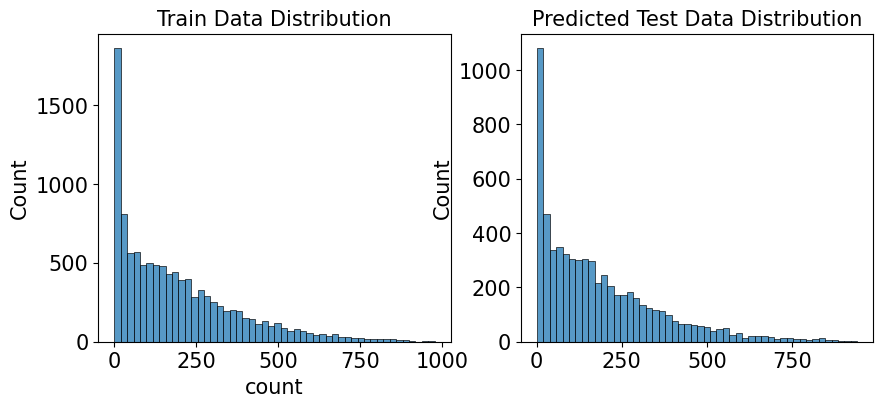

In [63]:
import seaborn as sns
import matplotlib.pyplot as plt

randomforest_preds = gridsearch_random_forest_model.best_estimator_.predict(X_test)

figure, axes = plt.subplots(ncols=2)
figure.set_size_inches(10,4)

sns.histplot(y, bins=50, ax=axes[0])
axes[0].set_title('Train Data Distribution')
sns.histplot(np.exp(randomforest_preds), bins=50, ax=axes[1])
axes[1].set_title('Predicted Test Data Distribution');

In [64]:
submission['count'] = np.exp(randomforest_preds) #지수변환
submission.to_csv('submission.csv', index=False)

## 핵심 요약
- 캐글 경진대회 프로세스는 크게 경진대회 이해 -> 탐색적 데이터 분석 -> 베이스라인 모델 -> 성능 개선 순으로 진행된다. 일반적인 머신러닝/딥러닝 문제를 해결할 때도 그대로 적용할 수 있다.
    - 경진대회 이해 : 단계에서는 대회의 취지와 문제 유형을 정확히 파악하고, 평가지표를 확인한다
    - 탐색적 데이터 분석 : 단계에서는 시각화를 포함한 각종 기법을 동원해 데이터를 분석하여, 피처 엔지니어링과 모델링 전략을 수립한다.
    - 베이스라인 모델 : 단계에서는 본걱적인 최적화에 앞서 기본 모델을 제작한다. 유사한 문제를 풀 때 업계에서 흔히 쓰는 모델이나 직관적으로 떠로르는 모델을 선택한다.
    - 성능 개선 : 단계에서는 베이스라인 모델보다 나은 성능을 목ㅍ로 각종 최적화를 진행한다.
- 타깃값이 정규분포에 가까울수록 회귀 모델의 성능이 좋다. 한쪽으로 치우친 타깃값은 로그변환하면 정규분포에 가까워지고, 결괏값을 지수변환하면 원래 타깃값 형태로 복원된다.(타깃값 변환)
- 훈련 데이터에서 이상치를 제거하면 일반화 성능이 높아질 수 있다.(이상치 제거)
- 기존 피처를 분해/조합하여 모델링에 도움되는 새로운 피처를 추가할 수 있다.(파생 피처 추가)
- 반대로 불필요한 피처를 제거해주면 성능도 좋아지고, 훈련 속도도 빨라지낟.(피처 제거)
- 선형 회귀, 릿지, 라쏘 모델은 회귀 문제를 푸는 대표적인 모델이지만, 너무 기본적이라 실전에서 단독으로 최상의 성능을 기대하기는 어렵ㄴ다.
- 랜덤 포레스트 회귀 모델은 여러 모델을 묶어 (대체로) 더 나은 성능을 이끌어내는 간단하고 유용한 기법이다.
- 그리드서치는 고차 검증으로 최적의 하이퍼파라미터 값을 찾아주는 기법이다.